# Drift and Diffusion in XENON1T


La forma degli eventi S2 è determinata da 3 parametri: **drift velocity**, **diffusion constant** e **SPE waveform model**. Qui ci concentriamo sui primi 2 parametri.

## Drift Velocity

Viene calcolato dalla differenza dei centri di S1 e the S2 ed è contenuto in `event_basics`. 

In [1]:
import os
import numpy as np
import pandas as pd
import drift_diffusion as dd

In [2]:
count = 0
fnames = []
for p, d, files in os.walk(os.getcwd()):
    d.sort()
    for f in sorted(files):
        if f.endswith(".h5"):
            fnames.append(f)
            count+=1
if count>0:
    print('Data file n.',count)
    print(fnames)

Data file n. 5
['data_170204_1410-170205_0012.h5', 'data_170204_1410-170621_0617.h5', 'data_170205_0012-170205_1013.h5', 'data_170205_1013-170205_2015.h5', 'data_170205_2015-170206_0617.h5']


In [3]:
data = pd.read_hdf('data_170204_1410-170621_0617.h5', 'data')

In [4]:
# to open data from contexts
import straxen
st = straxen.contexts.xenon1t_dali()
runs = st.select_runs(available='event_info',run_mode='background_stable')

Checking data availability: 100%|██████████| 5/5 [00:33<00:00,  6.76s/it]


In [9]:
print(len(runs))
data = select_data_from_runs( runs, 43)

43


NameError: name 'select_data_from_runs' is not defined

/home/valerio/miniconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Drift velocity determined at 1.339 km/s


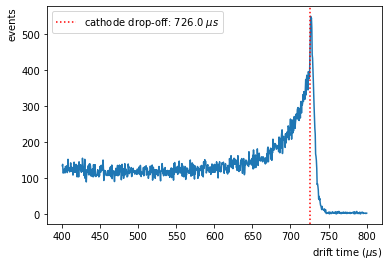

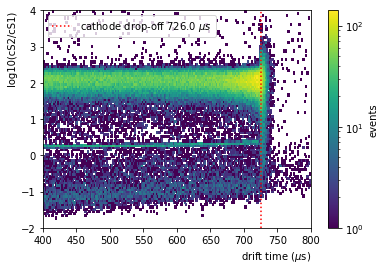

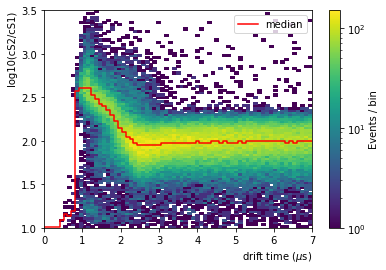

In [4]:
vd = dd.drift_velocity(data,True)

### Drift Time

Il massimo nello spettro del drift time è legato a eventi che avvengono al catodo; il rate di eventi aumenta scendendo nella TPC, dato che la schermo di xenon (da gamma provenienti da materiali sotto la TPC) si riduce sempre di più; fino a diminuire improvvisamente dato che S2 non possoono essere collezionati da sotto il catodo.

### S2/S1 Ratio
* **low S2/S1 events**, sono prodotti da electron clouds che si trovano nella regione di inversione del campo al catodo, parte della carica va verso il bottom screen e non risale all'anodo
* **large S2s** sono prodotti in regione con alto campo vicino i fili del catodo; questo sopprime l'effetto di ricombinazione delle coppie, aumentando quindi S2

### Drift time of gate events

Gli eventi creati al gate non sono visibili a tempi più bassi, questi eventi possono essere generati anche nel sottile strato tra il gate e l'anodo.

A tempi sotto i 3 $\mu$s il rapporto $cS1/cS2$ sale, questo è dovuto al fatto che il campo elettrico cresce passando il gate sopprimento l'effetto di ricombinazione e quindi aumentando S2 a discapito di S1.

La posizione orientativo del gate è dove c'è il rapido cambio intorno a 1.5$~\mu$s.

## Diffusion Constant

### Richiamo di teoria

The diffusion constant $D$ describes the diffusive broadening of electron clouds, and eventually the S2 signals, with increasing drift time.

Non ci sono molti lavori a riguardo, si prende come riferimento quello di [Sorensen](https://arxiv.org/abs/1102.2865) che definisce la devisione standard del segnale S2 (per un infinitely thin gas gap):

\begin{equation}
\sigma = \frac{\sqrt{2 D t}}{v}
\end{equation}
il numeratore è la larghezza longitudinale dell'electron cloud con $t$ the drift time, $v$ è la drift velocity. 

Per $t$ lunghi ($>30\mu$s per Sorensen), la diffusione rende la forma di S2 ancora una gaussiana approssimata, si usa una versione modificata dell'equazionee:

\begin{equation}
\sigma = \sqrt{\frac{2 D t}{v^2} + {\sigma_0}^2}
\end{equation}
dove $\sigma_0$ è una costante da settare; se la risposta al SPE fosse una gaussiana perfetta, $\sigma_0$ sarebbe la larghezza di very shallow S2s.

Viene utilizzata l'area al 50% area $r_{50}$ per misurare la larghezza di S2, in modo da evitare la coda. Facendo l'aprossimazione di gaussiana $r_{50} \approx 1.349 \sigma$ si può scrivere:

\begin{equation}
r_{50} = \sqrt{\frac{3.6395 D t}{v^2} + {w_0}^2}
\end{equation}

### S2 width vs energy
la larghezza dipende dall'energia per 2 effetti:

* i segnali S2 hanno una certa distribuzione per la width dovuta al numero finito di elettroni, a **bassa statistica** gli stimatori della larghezza non sono molto corretti;
* al contrario, per gli S2 ad **alte energie** c'è la saturation dell'ADC, che taglia parte dell'area e questo provoca un aumento della larghezza (con S2 ~ 30k PE) (vedere meglio questa cosa)

Computing likelihoods: 12528it [00:51, 238.43it/s]                           

Diffusion constant = 35.83 +/- 13.57 cm^2/s 


/home/valerio/Dropbox/Ricerca/PostDocXenon/1.Analysis/xenon-notes/drift_diffusion/drift_diffusion.py:203: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('diffusion_constant.png')


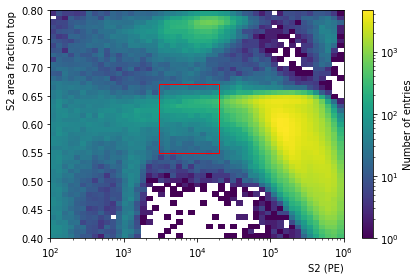

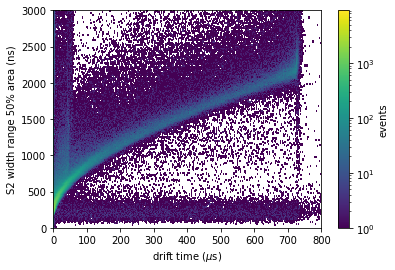

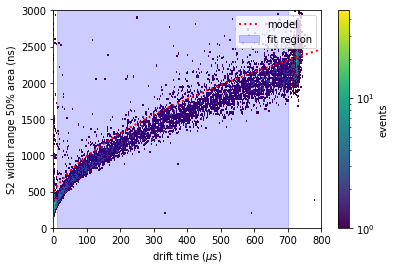

Computing likelihoods: 12550it [01:10, 238.43it/s]

In [5]:
s2_bounds = (3e3, 2e4)
aft_bounds = (0.55, 0.67)
fit_range = (10, 700)
d_const, d_const_err = dd.diffusion_constant(data,s2_bounds,aft_bounds,fit_range,vd,True)

### Taglio su S2 e S2 area fraction top (AFT)

AFT diminuisce ad alte energia: questo anche è dovuto alla saturazione nel top array. Jelle utilizza i tagli mostrati nel grafico: s2[10k:20k] e AFT[0.55:0.7].
Il taglio su S2 rimuove:
* eventi di alta energia dove si ha la saturazione dell'ADC (e questo allarga artificialmente S2-width)
* eventi di bassa energia dove non vale l'equazione della diffusione per la statistica bassa

Il taglio sulla frazione vista dai PMT in alto (S2_AFT) rimuove:
* eventi che avvengono nelle vicinanze del top array (o nel gas) che hanno un `drift time` breve e una larghezza maggiore

### Fit per determinare the Diffusion Constant
Per fare il fit vengono usati soltanto tempi tra 50 e 350 us:
* in basso per garantire che S2 abbia una distribuzione guassiana
* in alto per rimuovere eventi ad alta statistica che producono eventi anomali

In [7]:
veld = np.zeros(count)
diff = np.zeros(count)
for i in range(count):
    data = pd.read_hdf(fnames[i], 'data')
    veld[i] = dd.drift_velocity(data)
    diff[i] = dd.diffusion_constant(data,s2_bounds,aft_bounds,fit_range,vd)

/home/valerio/miniconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Drift velocity determined at 1.338 km/s



Computing likelihoods:  33%|███▎      | 4094/12500 [00:22<00:39, 213.04it/s]


Computing likelihoods:  71%|███████▏  | 8934/12500 [00:44<00:14, 240.77it/s]


Computing likelihoods: 100%|█████████▉| 12497/12500 [00:59<00:00, 262.52it/s]
Computing likelihoods: 12535it [00:59, 287.90it/s]                           

Diffusion constant = 32.69 cm^2/s
Drift velocity determined at 1.339 km/s




Computing likelihoods:   0%|          | 0/12500 [00:00<?, ?it/s]

Computing likelihoods:   0%|          | 19/12500 [00:00<01:08, 181.59it/s]

Computing likelihoods:   0%|          | 38/12500 [00:00<01:08, 181.59it/s]

Computing likelihoods:   0%|          | 57/12500 [00:00<01:08, 181.95it/s]

Computing likelihoods:   1%|          | 75/12500 [00:00<01:09, 178.48it/s]

Computing likelihoods:   1%|          | 93/12500 [00:00<01:09, 178.79it/s]

Computing likelihoods:   1%|          | 112/12500 [00:00<01:08, 179.78it/s]

Computing likelihoods:   1%|          | 131/12500 [00:00<01:08, 181.70it/s]

Computing likelihoods:   1%|          | 150/12500 [00:00<01:07, 182.70it/s]

Computing likelihoods:   1%|▏         | 168/12500 [00:00<01:09, 177.17it/s]

Computing likelihoods:   1%|▏         | 186/12500 [00:01<01:09, 177.23it/s]

Computing likelihoods:   2%|▏         | 204/12500 [00:01<01:09, 177.40it/s]

Computing likelihoods:   2%|▏         | 223/12500 [00:01<01:08, 178.72it/s]

Computing lik

Computing likelihoods:  37%|███▋      | 4577/12500 [00:20<00:35, 220.32it/s]

Computing likelihoods:  37%|███▋      | 4600/12500 [00:21<00:40, 196.82it/s]

Computing likelihoods:  37%|███▋      | 4621/12500 [00:21<00:40, 196.50it/s]

Computing likelihoods:  37%|███▋      | 4644/12500 [00:21<00:38, 204.97it/s]

Computing likelihoods:  37%|███▋      | 4666/12500 [00:21<00:37, 208.87it/s]

Computing likelihoods:  38%|███▊      | 4688/12500 [00:21<00:37, 211.04it/s]

Computing likelihoods:  38%|███▊      | 4715/12500 [00:21<00:35, 222.35it/s]

Computing likelihoods:  38%|███▊      | 4742/12500 [00:21<00:33, 231.48it/s]

Computing likelihoods:  38%|███▊      | 4769/12500 [00:21<00:32, 240.95it/s]

Computing likelihoods:  38%|███▊      | 4795/12500 [00:21<00:31, 244.05it/s]

Computing likelihoods:  39%|███▊      | 4822/12500 [00:22<00:30, 251.26it/s]

Computing likelihoods:  39%|███▉      | 4848/12500 [00:22<00:30, 251.79it/s]

Computing likelihoods:  39%|███▉      | 4874/12500 [00:22<00:31,

Computing likelihoods:  75%|███████▍  | 9346/12500 [00:42<00:15, 206.45it/s]

Computing likelihoods:  75%|███████▍  | 9372/12500 [00:42<00:14, 217.83it/s]

Computing likelihoods:  75%|███████▌  | 9399/12500 [00:42<00:13, 231.19it/s]

Computing likelihoods:  75%|███████▌  | 9424/12500 [00:42<00:13, 233.64it/s]

Computing likelihoods:  76%|███████▌  | 9449/12500 [00:42<00:12, 235.79it/s]

Computing likelihoods:  76%|███████▌  | 9473/12500 [00:42<00:12, 234.67it/s]

Computing likelihoods:  76%|███████▌  | 9497/12500 [00:42<00:12, 233.62it/s]

Computing likelihoods:  76%|███████▌  | 9524/12500 [00:42<00:12, 241.43it/s]

Computing likelihoods:  76%|███████▋  | 9549/12500 [00:42<00:12, 232.22it/s]

Computing likelihoods:  77%|███████▋  | 9574/12500 [00:42<00:12, 236.70it/s]

Computing likelihoods:  77%|███████▋  | 9598/12500 [00:43<00:12, 232.04it/s]

Computing likelihoods:  77%|███████▋  | 9622/12500 [00:43<00:12, 229.07it/s]

Computing likelihoods:  77%|███████▋  | 9646/12500 [00:43<00:12,

Diffusion constant = 27.40 cm^2/s
Drift velocity determined at 1.339 km/s





Computing likelihoods:   0%|          | 0/12500 [00:00<?, ?it/s]


Computing likelihoods:   0%|          | 20/12500 [00:00<01:05, 191.70it/s]


Computing likelihoods:   0%|          | 38/12500 [00:00<01:06, 187.85it/s]


Computing likelihoods:   0%|          | 56/12500 [00:00<01:07, 184.26it/s]


Computing likelihoods:   1%|          | 74/12500 [00:00<01:07, 182.79it/s]


Computing likelihoods:   1%|          | 92/12500 [00:00<01:08, 180.04it/s]


Computing likelihoods:   1%|          | 110/12500 [00:00<01:09, 178.42it/s]


Computing likelihoods:   1%|          | 129/12500 [00:00<01:09, 178.91it/s]


Computing likelihoods:   1%|          | 147/12500 [00:00<01:09, 178.57it/s]


Computing likelihoods:   1%|▏         | 165/12500 [00:00<01:09, 177.72it/s]


Computing likelihoods:   1%|▏         | 183/12500 [00:01<01:09, 177.93it/s]


Computing likelihoods:   2%|▏         | 201/12500 [00:01<01:09, 176.94it/s]


Computing likelihoods:   2%|▏         | 220/12500 [00:01<01:09, 177.84it/s]



Computing likelihoods:  32%|███▏      | 3978/12500 [00:20<00:41, 205.28it/s]


Computing likelihoods:  32%|███▏      | 4002/12500 [00:20<00:39, 213.51it/s]


Computing likelihoods:  32%|███▏      | 4027/12500 [00:20<00:38, 222.52it/s]


Computing likelihoods:  32%|███▏      | 4050/12500 [00:20<00:37, 224.55it/s]


Computing likelihoods:  33%|███▎      | 4075/12500 [00:20<00:36, 229.04it/s]


Computing likelihoods:  33%|███▎      | 4099/12500 [00:20<00:37, 222.31it/s]


Computing likelihoods:  33%|███▎      | 4122/12500 [00:20<00:39, 213.57it/s]


Computing likelihoods:  33%|███▎      | 4144/12500 [00:20<00:42, 197.43it/s]


Computing likelihoods:  33%|███▎      | 4165/12500 [00:21<00:46, 180.76it/s]


Computing likelihoods:  33%|███▎      | 4184/12500 [00:21<00:50, 163.57it/s]


Computing likelihoods:  34%|███▎      | 4204/12500 [00:21<00:48, 172.04it/s]


Computing likelihoods:  34%|███▍      | 4228/12500 [00:21<00:44, 186.44it/s]


Computing likelihoods:  34%|███▍      | 4248/12500 [

Computing likelihoods:  61%|██████▏   | 7670/12500 [00:40<00:25, 189.05it/s]


Computing likelihoods:  62%|██████▏   | 7690/12500 [00:40<00:25, 186.31it/s]


Computing likelihoods:  62%|██████▏   | 7709/12500 [00:40<00:25, 185.95it/s]


Computing likelihoods:  62%|██████▏   | 7732/12500 [00:41<00:24, 194.41it/s]


Computing likelihoods:  62%|██████▏   | 7752/12500 [00:41<00:25, 185.83it/s]


Computing likelihoods:  62%|██████▏   | 7777/12500 [00:41<00:23, 199.57it/s]


Computing likelihoods:  62%|██████▏   | 7798/12500 [00:41<00:23, 200.25it/s]


Computing likelihoods:  63%|██████▎   | 7825/12500 [00:41<00:21, 216.99it/s]


Computing likelihoods:  63%|██████▎   | 7848/12500 [00:41<00:22, 209.76it/s]


Computing likelihoods:  63%|██████▎   | 7872/12500 [00:41<00:21, 214.24it/s]


Computing likelihoods:  63%|██████▎   | 7896/12500 [00:41<00:21, 218.61it/s]


Computing likelihoods:  63%|██████▎   | 7919/12500 [00:41<00:21, 211.97it/s]


Computing likelihoods:  64%|██████▎   | 7941/12500 [

Computing likelihoods:  93%|█████████▎| 11625/12500 [01:01<00:04, 200.14it/s]


Computing likelihoods:  93%|█████████▎| 11651/12500 [01:02<00:03, 214.63it/s]


Computing likelihoods:  93%|█████████▎| 11676/12500 [01:02<00:03, 221.28it/s]


Computing likelihoods:  94%|█████████▎| 11699/12500 [01:02<00:04, 174.05it/s]


Computing likelihoods:  94%|█████████▍| 11719/12500 [01:02<00:04, 163.89it/s]


Computing likelihoods:  94%|█████████▍| 11737/12500 [01:02<00:04, 156.78it/s]


Computing likelihoods:  94%|█████████▍| 11754/12500 [01:02<00:04, 160.11it/s]


Computing likelihoods:  94%|█████████▍| 11772/12500 [01:02<00:04, 163.61it/s]


Computing likelihoods:  94%|█████████▍| 11793/12500 [01:02<00:04, 175.15it/s]


Computing likelihoods:  94%|█████████▍| 11812/12500 [01:03<00:04, 169.20it/s]


Computing likelihoods:  95%|█████████▍| 11840/12500 [01:03<00:03, 190.84it/s]


Computing likelihoods:  95%|█████████▍| 11861/12500 [01:03<00:03, 181.41it/s]


Computing likelihoods:  95%|█████████▌| 

Diffusion constant = 30.84 cm^2/s
Drift velocity determined at 1.337 km/s






Computing likelihoods:   0%|          | 0/12500 [00:00<?, ?it/s]



Computing likelihoods:   0%|          | 14/12500 [00:00<01:29, 139.30it/s]



Computing likelihoods:   0%|          | 27/12500 [00:00<01:33, 133.47it/s]



Computing likelihoods:   0%|          | 40/12500 [00:00<01:34, 131.99it/s]



Computing likelihoods:   0%|          | 53/12500 [00:00<01:38, 125.94it/s]



Computing likelihoods:   1%|          | 64/12500 [00:00<01:45, 117.89it/s]



Computing likelihoods:   1%|          | 77/12500 [00:00<01:43, 120.55it/s]



Computing likelihoods:   1%|          | 90/12500 [00:00<01:43, 120.46it/s]



Computing likelihoods:   1%|          | 101/12500 [00:00<01:50, 111.97it/s]



Computing likelihoods:   1%|          | 112/12500 [00:00<01:56, 106.54it/s]



Computing likelihoods:   1%|          | 125/12500 [00:01<01:51, 110.85it/s]



Computing likelihoods:   1%|          | 138/12500 [00:01<01:48, 114.26it/s]



Computing likelihoods:   1%|          | 151/12500 [00:01<01:46, 11

Computing likelihoods:  19%|█▊        | 2328/12500 [00:19<01:22, 123.16it/s]



Computing likelihoods:  19%|█▊        | 2342/12500 [00:20<01:19, 127.62it/s]



Computing likelihoods:  19%|█▉        | 2356/12500 [00:20<01:18, 129.66it/s]



Computing likelihoods:  19%|█▉        | 2371/12500 [00:20<01:16, 132.72it/s]



Computing likelihoods:  19%|█▉        | 2388/12500 [00:20<01:12, 140.34it/s]



Computing likelihoods:  19%|█▉        | 2405/12500 [00:20<01:08, 146.72it/s]



Computing likelihoods:  19%|█▉        | 2421/12500 [00:20<01:08, 146.86it/s]



Computing likelihoods:  19%|█▉        | 2436/12500 [00:20<01:13, 137.65it/s]



Computing likelihoods:  20%|█▉        | 2450/12500 [00:20<01:14, 134.96it/s]



Computing likelihoods:  20%|█▉        | 2467/12500 [00:20<01:10, 141.86it/s]



Computing likelihoods:  20%|█▉        | 2482/12500 [00:21<01:17, 129.76it/s]



Computing likelihoods:  20%|█▉        | 2498/12500 [00:21<01:13, 135.83it/s]



Computing likelihoods:  20%|██        | 

Computing likelihoods:  45%|████▍     | 5620/12500 [00:39<00:46, 148.62it/s]



Computing likelihoods:  45%|████▌     | 5641/12500 [00:40<00:42, 160.30it/s]



Computing likelihoods:  45%|████▌     | 5658/12500 [00:40<00:48, 140.53it/s]



Computing likelihoods:  45%|████▌     | 5676/12500 [00:40<00:45, 149.79it/s]



Computing likelihoods:  46%|████▌     | 5693/12500 [00:40<00:44, 152.82it/s]



Computing likelihoods:  46%|████▌     | 5709/12500 [00:40<00:44, 153.39it/s]



Computing likelihoods:  46%|████▌     | 5727/12500 [00:40<00:42, 159.88it/s]



Computing likelihoods:  46%|████▌     | 5745/12500 [00:40<00:41, 162.21it/s]



Computing likelihoods:  46%|████▌     | 5762/12500 [00:40<00:42, 159.43it/s]



Computing likelihoods:  46%|████▌     | 5781/12500 [00:40<00:40, 167.40it/s]



Computing likelihoods:  46%|████▋     | 5800/12500 [00:41<00:38, 173.54it/s]



Computing likelihoods:  47%|████▋     | 5821/12500 [00:41<00:36, 181.57it/s]



Computing likelihoods:  47%|████▋     | 

Computing likelihoods:  73%|███████▎  | 9175/12500 [00:59<00:20, 158.52it/s]



Computing likelihoods:  74%|███████▎  | 9192/12500 [01:00<00:21, 150.64it/s]



Computing likelihoods:  74%|███████▎  | 9208/12500 [01:00<00:22, 147.70it/s]



Computing likelihoods:  74%|███████▍  | 9224/12500 [01:00<00:21, 149.06it/s]



Computing likelihoods:  74%|███████▍  | 9244/12500 [01:00<00:20, 157.80it/s]



Computing likelihoods:  74%|███████▍  | 9260/12500 [01:00<00:20, 156.25it/s]



Computing likelihoods:  74%|███████▍  | 9277/12500 [01:00<00:20, 158.64it/s]



Computing likelihoods:  74%|███████▍  | 9297/12500 [01:00<00:19, 167.00it/s]



Computing likelihoods:  75%|███████▍  | 9314/12500 [01:00<00:19, 162.60it/s]



Computing likelihoods:  75%|███████▍  | 9332/12500 [01:00<00:19, 165.81it/s]



Computing likelihoods:  75%|███████▍  | 9349/12500 [01:00<00:19, 158.64it/s]



Computing likelihoods:  75%|███████▍  | 9369/12500 [01:01<00:18, 167.86it/s]



Computing likelihoods:  75%|███████▌  | 

Diffusion constant = 35.61 cm^2/s
[0.00013379 0.00013389 0.00013389 0.0001337 ] [32.68618715 27.39769572 30.84399895 35.61113253]






Computing likelihoods: 12550it [01:27, 205.36it/s]

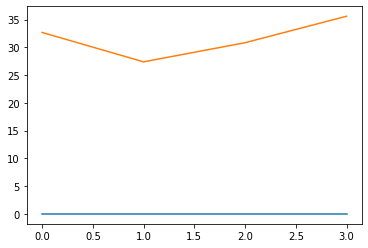

In [11]:
import matplotlib.pyplot as plt
plt.plot(veld)
plt.plot(diff)